# Ising-PyTorch-CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = np.loadtxt('.\\data\\binned_configurations_array.csv', delimiter=',')

In [3]:
X = data[:, :-1]
T = data[:, -1]

In [4]:
X.shape  # 41 temperatures, 100 samples each. 12x12 lattice with 144 sites.

(4100, 144)

In [5]:
T.shape   # Single label (temperature) for each sample

(4100,)

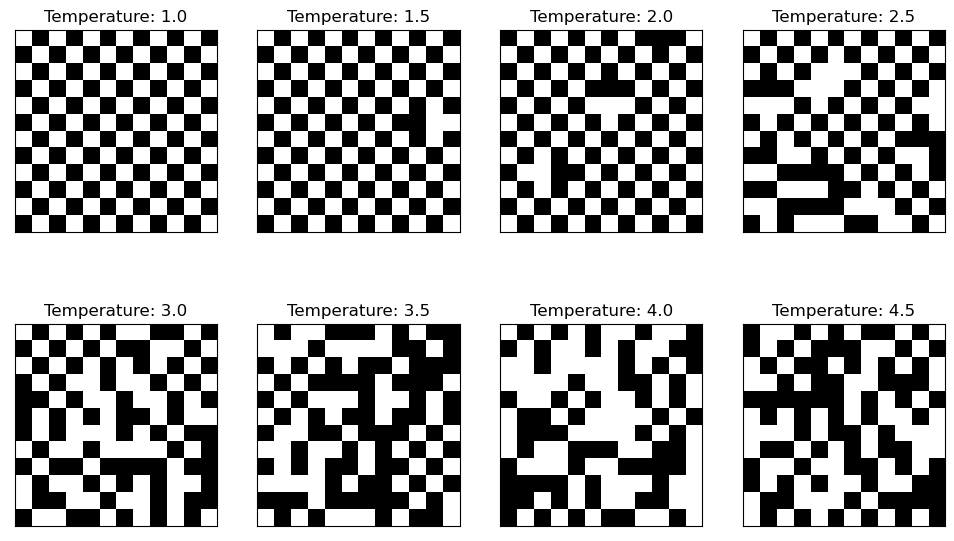

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(12, 7))
index = 0

for i in range(2):
    for j in range(4):

        axs[i, j].imshow(X[index*500].reshape(12, 12), cmap="binary", origin='lower')

        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(f'Temperature: {T[index*500]}')

        index += 1

In [7]:
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, T_train, T_val = train_test_split(X_train, T_train, test_size=0.25, random_state=1, shuffle=True)

Tc = 2.269

y_train = (T_train < Tc).astype(int)
y_test = (T_test < Tc).astype(int)
y_val = (T_val < Tc).astype(int)

In [8]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2460, 144)
X_val shape: (820, 144)
X_test shape: (820, 144)
y_train shape: (2460,)
y_val shape: (820,)
y_test shape: (820,)


In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, 12, 12))
X_val = np.reshape(X_val, (X_val.shape[0], 1, 12, 12))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 12, 12))

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [11]:
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

In [12]:
next(iter(test_dl))[0].shape

torch.Size([64, 1, 12, 12])

In [14]:
initial_model = nn.Sequential(
    
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(576, 16),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(16, 1),
    nn.Sigmoid()

)

In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(initial_model.parameters(), lr=0.001, weight_decay=0.1)
num_epochs = 50

In [16]:
def train(model, num_epochs, train_dl, valid_dl):

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    best_val_loss = np.inf
    patience = 10
    
    for epoch in range(num_epochs):

        for x_batch, y_batch in train_dl:
            
            pred = model(x_batch)[:, 0]
                        
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()

            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:

                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch + 1}    Train Accuracy: {accuracy_hist_train[epoch]:.4f}   Train Loss: {loss_hist_train[epoch]:.4f}     Valid Accuracy: {accuracy_hist_valid[epoch]:.4f}   Valid Loss: {loss_hist_valid[epoch]:.4f}')
        
        if loss_hist_valid[epoch] < best_val_loss:
            
            best_val_loss = loss_hist_valid[epoch]
            early_stop_counter = patience
            best_model = model
        
        else:    
            early_stop_counter -= 1
            
        if early_stop_counter == 0:
            break
            
    print(f'\n Best validation accuracy = {np.max(accuracy_hist_valid)} \n\n')
            
    return loss_hist_train[:epoch+1], accuracy_hist_train[:epoch+1], loss_hist_valid[:epoch+1], accuracy_hist_valid[:epoch+1], best_model

In [17]:
initial_hist = train(initial_model, num_epochs, train_dl, valid_dl)

Epoch 1    Train Accuracy: 0.8407   Train Loss: 0.3440     Valid Accuracy: 0.9659   Valid Loss: 0.1260
Epoch 2    Train Accuracy: 0.9634   Train Loss: 0.1208     Valid Accuracy: 0.9646   Valid Loss: 0.1091
Epoch 3    Train Accuracy: 0.9646   Train Loss: 0.1124     Valid Accuracy: 0.9646   Valid Loss: 0.1083
Epoch 4    Train Accuracy: 0.9671   Train Loss: 0.1090     Valid Accuracy: 0.9622   Valid Loss: 0.1124
Epoch 5    Train Accuracy: 0.9671   Train Loss: 0.1096     Valid Accuracy: 0.9634   Valid Loss: 0.1083
Epoch 6    Train Accuracy: 0.9671   Train Loss: 0.1133     Valid Accuracy: 0.9634   Valid Loss: 0.1161
Epoch 7    Train Accuracy: 0.9671   Train Loss: 0.1139     Valid Accuracy: 0.9622   Valid Loss: 0.1153
Epoch 8    Train Accuracy: 0.9646   Train Loss: 0.1135     Valid Accuracy: 0.9622   Valid Loss: 0.1084
Epoch 9    Train Accuracy: 0.9675   Train Loss: 0.1093     Valid Accuracy: 0.9634   Valid Loss: 0.1129
Epoch 10    Train Accuracy: 0.9699   Train Loss: 0.1106     Valid Accurac

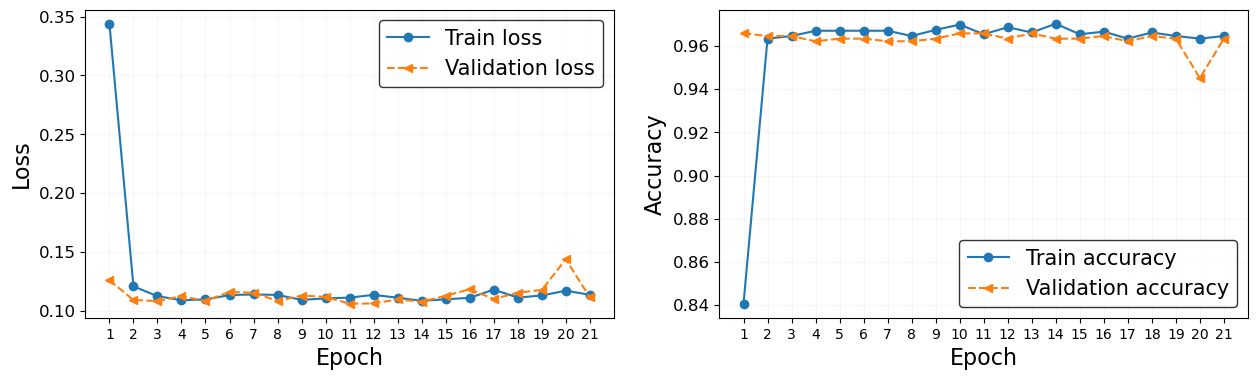

In [19]:
x_arr = np.arange(len(initial_hist[0])) + 1
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, initial_hist[0], '-o', label='Train loss')
ax.plot(x_arr, initial_hist[2], '--<', label='Validation loss')
ax.legend(fontsize=15, frameon=True, edgecolor='k')
ax.set_xlabel('Epoch', size=16)
ax.set_ylabel('Loss', size=16)
ax.set_xticks(np.arange(len(initial_hist[0]))+1)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=12)
ax.grid(alpha=0.1)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, initial_hist[1], '-o', label='Train accuracy')
ax.plot(x_arr, initial_hist[3], '--<', label='Validation accuracy')
ax.legend(fontsize=15, frameon=True, edgecolor='k')
ax.set_xlabel('Epoch', size=16)
ax.set_ylabel('Accuracy', size=16)
ax.set_xticks(np.arange(len(initial_hist[1]))+1)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=12)
ax.grid(alpha=0.1)

plt.show()

In [20]:
best_initial_model = initial_hist[-1]
pred = best_initial_model(X_test)[:, 0]
is_correct = ((pred >= 0.5).float() == y_test).int()
test_accuracy = (is_correct.sum() / is_correct.shape[0]).item()
print(f'Test set accuracy = {test_accuracy}')

Test set accuracy = 0.9707317352294922


In [24]:
# Check incorrect predictions

for i in range(X_test.shape[0]):

    test_index = i # choose individual example from test set (integer from 0 to 819) 

    my_X = X_test[test_index]
    my_y = y_test[test_index]
    my_T = T_test[test_index]

    my_X = torch.unsqueeze(my_X, 0)   # Need additional first dimension (corresponding to batch size) for nn.Flatten

    result = best_initial_model(my_X)

    my_pred = int((result.item()) >= 0.5)
    
    if my_pred != int(my_y):

        print(f'Test set i = {i}:    T = {round(my_T, 2)},  y = {int(my_y)},  Prediction = {my_pred==int(my_y)}')


Test set i = 42:    T = 2.1,  y = 1,  Prediction = False
Test set i = 61:    T = 2.1,  y = 1,  Prediction = False
Test set i = 86:    T = 2.4,  y = 0,  Prediction = False
Test set i = 150:    T = 2.4,  y = 0,  Prediction = False
Test set i = 179:    T = 2.0,  y = 1,  Prediction = False
Test set i = 193:    T = 1.9,  y = 1,  Prediction = False
Test set i = 293:    T = 2.2,  y = 1,  Prediction = False
Test set i = 305:    T = 2.3,  y = 0,  Prediction = False
Test set i = 327:    T = 2.1,  y = 1,  Prediction = False
Test set i = 335:    T = 2.4,  y = 0,  Prediction = False
Test set i = 344:    T = 2.4,  y = 0,  Prediction = False
Test set i = 429:    T = 2.3,  y = 0,  Prediction = False
Test set i = 439:    T = 2.2,  y = 1,  Prediction = False
Test set i = 446:    T = 2.2,  y = 1,  Prediction = False
Test set i = 447:    T = 2.0,  y = 1,  Prediction = False
Test set i = 455:    T = 2.2,  y = 1,  Prediction = False
Test set i = 462:    T = 2.1,  y = 1,  Prediction = False
Test set i = 485:

In [25]:
unit_vals = [(32, 64, 256), (32, 64, 128), (32, 64, 64), (32, 64, 32), (32, 64, 16), (32, 32, 128), (32, 32, 64)]
weight_decay_vals = [0.001, 0.01, 0.1]
dropout_vals = [0.1, 0.2]
lr = 0.001

tuning_results_0p001 = np.empty(shape=(7,3,2), dtype=object)
best_val_acc_0p001 = 0
best_params_0p001 = ((0,0,0), 0, 0)

u = 0

for unit in unit_vals:
    
    w = 0

    for weight_decay in weight_decay_vals:

        d = 0

        for dropout in dropout_vals:

            print('\n')
            print(f'units = {unit}, weight decay = {weight_decay}, dropout = {dropout}:  \n')

            hd1 = unit[0]
            hd2 = unit[1]
            hd3 = unit[2]

            model = nn.Sequential(

                nn.Conv2d(in_channels=1, out_channels=hd1, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=hd1, out_channels=hd2, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Flatten(),
                nn.Linear(3*3*hd2, hd3),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(hd3, 1),
                nn.Sigmoid()

            )

            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            num_epochs = 50

            params = (unit, weight_decay, dropout)
            hist = train(model, num_epochs, train_dl, valid_dl)

            tuning_results_0p001[u, w, d] = [params, hist]
            
            val_acc = np.max(hist[3])
            if val_acc > best_val_acc_0p001:
                best_val_acc_0p001 = val_acc
                best_params_0p001 = params
                
            d += 1

        w += 1
        
    u += 1



units = (32, 64, 256), weight decay = 0.001, dropout = 0.1:  

Epoch 1    Train Accuracy: 0.8898   Train Loss: 0.2362     Valid Accuracy: 0.9537   Valid Loss: 0.1292
Epoch 2    Train Accuracy: 0.9691   Train Loss: 0.1023     Valid Accuracy: 0.9683   Valid Loss: 0.0808
Epoch 3    Train Accuracy: 0.9683   Train Loss: 0.0817     Valid Accuracy: 0.9646   Valid Loss: 0.0778
Epoch 4    Train Accuracy: 0.9642   Train Loss: 0.0885     Valid Accuracy: 0.9671   Valid Loss: 0.0797
Epoch 5    Train Accuracy: 0.9650   Train Loss: 0.0898     Valid Accuracy: 0.9646   Valid Loss: 0.0862
Epoch 6    Train Accuracy: 0.9671   Train Loss: 0.0849     Valid Accuracy: 0.9659   Valid Loss: 0.0775
Epoch 7    Train Accuracy: 0.9699   Train Loss: 0.0743     Valid Accuracy: 0.9659   Valid Loss: 0.0766
Epoch 8    Train Accuracy: 0.9711   Train Loss: 0.0704     Valid Accuracy: 0.9659   Valid Loss: 0.0778
Epoch 9    Train Accuracy: 0.9703   Train Loss: 0.0759     Valid Accuracy: 0.9659   Valid Loss: 0.0748
Epoch 10

Epoch 31    Train Accuracy: 0.9720   Train Loss: 0.0789     Valid Accuracy: 0.9671   Valid Loss: 0.0780

 Best validation accuracy = 0.9682926535606384 




units = (32, 64, 256), weight decay = 0.01, dropout = 0.2:  

Epoch 1    Train Accuracy: 0.9024   Train Loss: 0.2098     Valid Accuracy: 0.9463   Valid Loss: 0.1516
Epoch 2    Train Accuracy: 0.9598   Train Loss: 0.1189     Valid Accuracy: 0.9634   Valid Loss: 0.0932
Epoch 3    Train Accuracy: 0.9720   Train Loss: 0.0829     Valid Accuracy: 0.9659   Valid Loss: 0.0841
Epoch 4    Train Accuracy: 0.9671   Train Loss: 0.0828     Valid Accuracy: 0.9634   Valid Loss: 0.0801
Epoch 5    Train Accuracy: 0.9691   Train Loss: 0.0843     Valid Accuracy: 0.9659   Valid Loss: 0.0848
Epoch 6    Train Accuracy: 0.9703   Train Loss: 0.0793     Valid Accuracy: 0.9573   Valid Loss: 0.1032
Epoch 7    Train Accuracy: 0.9687   Train Loss: 0.0802     Valid Accuracy: 0.9659   Valid Loss: 0.0787
Epoch 8    Train Accuracy: 0.9646   Train Loss: 0.0897     V

Epoch 6    Train Accuracy: 0.9724   Train Loss: 0.0781     Valid Accuracy: 0.9683   Valid Loss: 0.0779
Epoch 7    Train Accuracy: 0.9744   Train Loss: 0.0728     Valid Accuracy: 0.9646   Valid Loss: 0.0730
Epoch 8    Train Accuracy: 0.9736   Train Loss: 0.0702     Valid Accuracy: 0.9659   Valid Loss: 0.0726
Epoch 9    Train Accuracy: 0.9728   Train Loss: 0.0721     Valid Accuracy: 0.9659   Valid Loss: 0.0720
Epoch 10    Train Accuracy: 0.9707   Train Loss: 0.0735     Valid Accuracy: 0.9610   Valid Loss: 0.0925
Epoch 11    Train Accuracy: 0.9695   Train Loss: 0.0706     Valid Accuracy: 0.9598   Valid Loss: 0.1027
Epoch 12    Train Accuracy: 0.9695   Train Loss: 0.0696     Valid Accuracy: 0.9622   Valid Loss: 0.0936
Epoch 13    Train Accuracy: 0.9744   Train Loss: 0.0718     Valid Accuracy: 0.9659   Valid Loss: 0.0731
Epoch 14    Train Accuracy: 0.9744   Train Loss: 0.0636     Valid Accuracy: 0.9598   Valid Loss: 0.0866
Epoch 15    Train Accuracy: 0.9724   Train Loss: 0.0631     Valid Ac

Epoch 24    Train Accuracy: 0.9667   Train Loss: 0.0822     Valid Accuracy: 0.9634   Valid Loss: 0.0790
Epoch 25    Train Accuracy: 0.9683   Train Loss: 0.0794     Valid Accuracy: 0.9634   Valid Loss: 0.0823
Epoch 26    Train Accuracy: 0.9691   Train Loss: 0.0774     Valid Accuracy: 0.9659   Valid Loss: 0.0812
Epoch 27    Train Accuracy: 0.9687   Train Loss: 0.0760     Valid Accuracy: 0.9646   Valid Loss: 0.0779
Epoch 28    Train Accuracy: 0.9715   Train Loss: 0.0789     Valid Accuracy: 0.9622   Valid Loss: 0.0920
Epoch 29    Train Accuracy: 0.9732   Train Loss: 0.0778     Valid Accuracy: 0.9537   Valid Loss: 0.1182
Epoch 30    Train Accuracy: 0.9683   Train Loss: 0.0800     Valid Accuracy: 0.9634   Valid Loss: 0.0784
Epoch 31    Train Accuracy: 0.9695   Train Loss: 0.0758     Valid Accuracy: 0.9610   Valid Loss: 0.0970
Epoch 32    Train Accuracy: 0.9679   Train Loss: 0.0802     Valid Accuracy: 0.9634   Valid Loss: 0.0779
Epoch 33    Train Accuracy: 0.9740   Train Loss: 0.0736     Vali

Epoch 25    Train Accuracy: 0.9890   Train Loss: 0.0369     Valid Accuracy: 0.9659   Valid Loss: 0.0872
Epoch 26    Train Accuracy: 0.9927   Train Loss: 0.0282     Valid Accuracy: 0.9659   Valid Loss: 0.0791
Epoch 27    Train Accuracy: 0.9939   Train Loss: 0.0247     Valid Accuracy: 0.9634   Valid Loss: 0.0837
Epoch 28    Train Accuracy: 0.9923   Train Loss: 0.0250     Valid Accuracy: 0.9695   Valid Loss: 0.0804
Epoch 29    Train Accuracy: 0.9959   Train Loss: 0.0193     Valid Accuracy: 0.9671   Valid Loss: 0.0799
Epoch 30    Train Accuracy: 0.9967   Train Loss: 0.0175     Valid Accuracy: 0.9659   Valid Loss: 0.0860

 Best validation accuracy = 0.9719512462615967 




units = (32, 64, 64), weight decay = 0.001, dropout = 0.2:  

Epoch 1    Train Accuracy: 0.8996   Train Loss: 0.2310     Valid Accuracy: 0.9634   Valid Loss: 0.1058
Epoch 2    Train Accuracy: 0.9683   Train Loss: 0.0869     Valid Accuracy: 0.9659   Valid Loss: 0.0813
Epoch 3    Train Accuracy: 0.9659   Train Loss: 0.0861 

Epoch 16    Train Accuracy: 0.9687   Train Loss: 0.0783     Valid Accuracy: 0.9659   Valid Loss: 0.0796
Epoch 17    Train Accuracy: 0.9720   Train Loss: 0.0769     Valid Accuracy: 0.9598   Valid Loss: 0.0946
Epoch 18    Train Accuracy: 0.9711   Train Loss: 0.0788     Valid Accuracy: 0.9659   Valid Loss: 0.0820
Epoch 19    Train Accuracy: 0.9671   Train Loss: 0.0785     Valid Accuracy: 0.9573   Valid Loss: 0.1000
Epoch 20    Train Accuracy: 0.9699   Train Loss: 0.0858     Valid Accuracy: 0.9634   Valid Loss: 0.0917

 Best validation accuracy = 0.9707317352294922 




units = (32, 64, 64), weight decay = 0.1, dropout = 0.1:  

Epoch 1    Train Accuracy: 0.8606   Train Loss: 0.3185     Valid Accuracy: 0.9646   Valid Loss: 0.1043
Epoch 2    Train Accuracy: 0.9646   Train Loss: 0.1134     Valid Accuracy: 0.9646   Valid Loss: 0.1047
Epoch 3    Train Accuracy: 0.9618   Train Loss: 0.1132     Valid Accuracy: 0.9634   Valid Loss: 0.1082
Epoch 4    Train Accuracy: 0.9630   Train Loss: 0.1158    

Epoch 14    Train Accuracy: 0.9720   Train Loss: 0.0701     Valid Accuracy: 0.9659   Valid Loss: 0.0736
Epoch 15    Train Accuracy: 0.9760   Train Loss: 0.0669     Valid Accuracy: 0.9634   Valid Loss: 0.0851
Epoch 16    Train Accuracy: 0.9740   Train Loss: 0.0709     Valid Accuracy: 0.9671   Valid Loss: 0.0740
Epoch 17    Train Accuracy: 0.9732   Train Loss: 0.0669     Valid Accuracy: 0.9683   Valid Loss: 0.0752
Epoch 18    Train Accuracy: 0.9760   Train Loss: 0.0635     Valid Accuracy: 0.9671   Valid Loss: 0.0738
Epoch 19    Train Accuracy: 0.9776   Train Loss: 0.0578     Valid Accuracy: 0.9659   Valid Loss: 0.0731
Epoch 20    Train Accuracy: 0.9756   Train Loss: 0.0597     Valid Accuracy: 0.9671   Valid Loss: 0.0747
Epoch 21    Train Accuracy: 0.9789   Train Loss: 0.0572     Valid Accuracy: 0.9695   Valid Loss: 0.0739
Epoch 22    Train Accuracy: 0.9744   Train Loss: 0.0595     Valid Accuracy: 0.9610   Valid Loss: 0.0903
Epoch 23    Train Accuracy: 0.9715   Train Loss: 0.0644     Vali

Epoch 1    Train Accuracy: 0.8467   Train Loss: 0.3139     Valid Accuracy: 0.9646   Valid Loss: 0.1067
Epoch 2    Train Accuracy: 0.9671   Train Loss: 0.1109     Valid Accuracy: 0.9634   Valid Loss: 0.1055
Epoch 3    Train Accuracy: 0.9667   Train Loss: 0.1104     Valid Accuracy: 0.9671   Valid Loss: 0.1075
Epoch 4    Train Accuracy: 0.9606   Train Loss: 0.1172     Valid Accuracy: 0.9646   Valid Loss: 0.1058
Epoch 5    Train Accuracy: 0.9650   Train Loss: 0.1131     Valid Accuracy: 0.9659   Valid Loss: 0.1059
Epoch 6    Train Accuracy: 0.9659   Train Loss: 0.1085     Valid Accuracy: 0.9659   Valid Loss: 0.1043
Epoch 7    Train Accuracy: 0.9679   Train Loss: 0.1098     Valid Accuracy: 0.9500   Valid Loss: 0.1306
Epoch 8    Train Accuracy: 0.9667   Train Loss: 0.1083     Valid Accuracy: 0.9671   Valid Loss: 0.1138
Epoch 9    Train Accuracy: 0.9634   Train Loss: 0.1141     Valid Accuracy: 0.9524   Valid Loss: 0.1294
Epoch 10    Train Accuracy: 0.9638   Train Loss: 0.1088     Valid Accurac

Epoch 11    Train Accuracy: 0.9699   Train Loss: 0.0699     Valid Accuracy: 0.9646   Valid Loss: 0.0783
Epoch 12    Train Accuracy: 0.9691   Train Loss: 0.0726     Valid Accuracy: 0.9659   Valid Loss: 0.0771
Epoch 13    Train Accuracy: 0.9703   Train Loss: 0.0768     Valid Accuracy: 0.9610   Valid Loss: 0.0978
Epoch 14    Train Accuracy: 0.9728   Train Loss: 0.0717     Valid Accuracy: 0.9659   Valid Loss: 0.0794
Epoch 15    Train Accuracy: 0.9732   Train Loss: 0.0671     Valid Accuracy: 0.9659   Valid Loss: 0.0782
Epoch 16    Train Accuracy: 0.9752   Train Loss: 0.0650     Valid Accuracy: 0.9671   Valid Loss: 0.0749
Epoch 17    Train Accuracy: 0.9752   Train Loss: 0.0641     Valid Accuracy: 0.9622   Valid Loss: 0.0785
Epoch 18    Train Accuracy: 0.9748   Train Loss: 0.0646     Valid Accuracy: 0.9634   Valid Loss: 0.0810
Epoch 19    Train Accuracy: 0.9776   Train Loss: 0.0606     Valid Accuracy: 0.9659   Valid Loss: 0.0752
Epoch 20    Train Accuracy: 0.9764   Train Loss: 0.0583     Vali

Epoch 4    Train Accuracy: 0.9585   Train Loss: 0.1206     Valid Accuracy: 0.9646   Valid Loss: 0.1207
Epoch 5    Train Accuracy: 0.9634   Train Loss: 0.1221     Valid Accuracy: 0.9634   Valid Loss: 0.1139
Epoch 6    Train Accuracy: 0.9634   Train Loss: 0.1144     Valid Accuracy: 0.9646   Valid Loss: 0.1104
Epoch 7    Train Accuracy: 0.9663   Train Loss: 0.1121     Valid Accuracy: 0.9646   Valid Loss: 0.1087
Epoch 8    Train Accuracy: 0.9667   Train Loss: 0.1132     Valid Accuracy: 0.9646   Valid Loss: 0.1128
Epoch 9    Train Accuracy: 0.9675   Train Loss: 0.1144     Valid Accuracy: 0.9671   Valid Loss: 0.1094
Epoch 10    Train Accuracy: 0.9642   Train Loss: 0.1130     Valid Accuracy: 0.9561   Valid Loss: 0.1251
Epoch 11    Train Accuracy: 0.9642   Train Loss: 0.1147     Valid Accuracy: 0.9646   Valid Loss: 0.1105
Epoch 12    Train Accuracy: 0.9667   Train Loss: 0.1147     Valid Accuracy: 0.9634   Valid Loss: 0.1066
Epoch 13    Train Accuracy: 0.9671   Train Loss: 0.1094     Valid Accu

Epoch 1    Train Accuracy: 0.8337   Train Loss: 0.3087     Valid Accuracy: 0.9463   Valid Loss: 0.1344
Epoch 2    Train Accuracy: 0.9663   Train Loss: 0.0973     Valid Accuracy: 0.9646   Valid Loss: 0.0835
Epoch 3    Train Accuracy: 0.9671   Train Loss: 0.0895     Valid Accuracy: 0.9646   Valid Loss: 0.0822
Epoch 4    Train Accuracy: 0.9606   Train Loss: 0.0912     Valid Accuracy: 0.9634   Valid Loss: 0.0919
Epoch 5    Train Accuracy: 0.9707   Train Loss: 0.0801     Valid Accuracy: 0.9646   Valid Loss: 0.0788
Epoch 6    Train Accuracy: 0.9728   Train Loss: 0.0747     Valid Accuracy: 0.9646   Valid Loss: 0.0777
Epoch 7    Train Accuracy: 0.9675   Train Loss: 0.0884     Valid Accuracy: 0.9512   Valid Loss: 0.1247
Epoch 8    Train Accuracy: 0.9679   Train Loss: 0.0850     Valid Accuracy: 0.9646   Valid Loss: 0.0801
Epoch 9    Train Accuracy: 0.9715   Train Loss: 0.0736     Valid Accuracy: 0.9646   Valid Loss: 0.0842
Epoch 10    Train Accuracy: 0.9695   Train Loss: 0.0752     Valid Accurac

Epoch 24    Train Accuracy: 0.9703   Train Loss: 0.0820     Valid Accuracy: 0.9646   Valid Loss: 0.0822
Epoch 25    Train Accuracy: 0.9667   Train Loss: 0.0844     Valid Accuracy: 0.9512   Valid Loss: 0.1149
Epoch 26    Train Accuracy: 0.9703   Train Loss: 0.0813     Valid Accuracy: 0.9671   Valid Loss: 0.0807
Epoch 27    Train Accuracy: 0.9683   Train Loss: 0.0777     Valid Accuracy: 0.9671   Valid Loss: 0.0791
Epoch 28    Train Accuracy: 0.9707   Train Loss: 0.0798     Valid Accuracy: 0.9671   Valid Loss: 0.0784
Epoch 29    Train Accuracy: 0.9703   Train Loss: 0.0787     Valid Accuracy: 0.9683   Valid Loss: 0.0848
Epoch 30    Train Accuracy: 0.9699   Train Loss: 0.0767     Valid Accuracy: 0.9634   Valid Loss: 0.0914
Epoch 31    Train Accuracy: 0.9679   Train Loss: 0.0788     Valid Accuracy: 0.9671   Valid Loss: 0.0789

 Best validation accuracy = 0.9682926535606384 




units = (32, 32, 128), weight decay = 0.1, dropout = 0.1:  

Epoch 1    Train Accuracy: 0.8484   Train Loss: 0.3240

Epoch 3    Train Accuracy: 0.9683   Train Loss: 0.0883     Valid Accuracy: 0.9646   Valid Loss: 0.0815
Epoch 4    Train Accuracy: 0.9679   Train Loss: 0.0824     Valid Accuracy: 0.9646   Valid Loss: 0.0802
Epoch 5    Train Accuracy: 0.9715   Train Loss: 0.0797     Valid Accuracy: 0.9634   Valid Loss: 0.0799
Epoch 6    Train Accuracy: 0.9687   Train Loss: 0.0792     Valid Accuracy: 0.9634   Valid Loss: 0.0777
Epoch 7    Train Accuracy: 0.9728   Train Loss: 0.0746     Valid Accuracy: 0.9659   Valid Loss: 0.0859
Epoch 8    Train Accuracy: 0.9703   Train Loss: 0.0780     Valid Accuracy: 0.9646   Valid Loss: 0.0775
Epoch 9    Train Accuracy: 0.9707   Train Loss: 0.0763     Valid Accuracy: 0.9622   Valid Loss: 0.0762
Epoch 10    Train Accuracy: 0.9715   Train Loss: 0.0759     Valid Accuracy: 0.9646   Valid Loss: 0.0760
Epoch 11    Train Accuracy: 0.9715   Train Loss: 0.0730     Valid Accuracy: 0.9634   Valid Loss: 0.0865
Epoch 12    Train Accuracy: 0.9703   Train Loss: 0.0747     Valid Accur

Epoch 20    Train Accuracy: 0.9687   Train Loss: 0.0787     Valid Accuracy: 0.9659   Valid Loss: 0.0841
Epoch 21    Train Accuracy: 0.9695   Train Loss: 0.0769     Valid Accuracy: 0.9561   Valid Loss: 0.1144
Epoch 22    Train Accuracy: 0.9659   Train Loss: 0.0902     Valid Accuracy: 0.9634   Valid Loss: 0.0880
Epoch 23    Train Accuracy: 0.9687   Train Loss: 0.0783     Valid Accuracy: 0.9634   Valid Loss: 0.0781
Epoch 24    Train Accuracy: 0.9724   Train Loss: 0.0747     Valid Accuracy: 0.9671   Valid Loss: 0.0785
Epoch 25    Train Accuracy: 0.9724   Train Loss: 0.0765     Valid Accuracy: 0.9634   Valid Loss: 0.0788
Epoch 26    Train Accuracy: 0.9695   Train Loss: 0.0847     Valid Accuracy: 0.9598   Valid Loss: 0.1056
Epoch 27    Train Accuracy: 0.9667   Train Loss: 0.0838     Valid Accuracy: 0.9646   Valid Loss: 0.0919
Epoch 28    Train Accuracy: 0.9671   Train Loss: 0.0793     Valid Accuracy: 0.9671   Valid Loss: 0.0797
Epoch 29    Train Accuracy: 0.9720   Train Loss: 0.0793     Vali

In [26]:
best_val_acc_0p001

0.97195125

In [27]:
best_params_0p001

((32, 64, 64), 0.001, 0.1)

In [47]:
final_model = nn.Sequential(
    
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(576, 64),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(64, 1),
    nn.Sigmoid()

)

In [48]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001, weight_decay=0.001)
num_epochs = 50

In [49]:
final_hist = train(final_model, num_epochs, train_dl, valid_dl)

Epoch 1    Train Accuracy: 0.8728   Train Loss: 0.2751     Valid Accuracy: 0.9622   Valid Loss: 0.1067
Epoch 2    Train Accuracy: 0.9638   Train Loss: 0.1020     Valid Accuracy: 0.9659   Valid Loss: 0.0963
Epoch 3    Train Accuracy: 0.9679   Train Loss: 0.0865     Valid Accuracy: 0.9671   Valid Loss: 0.0871
Epoch 4    Train Accuracy: 0.9650   Train Loss: 0.0844     Valid Accuracy: 0.9646   Valid Loss: 0.0932
Epoch 5    Train Accuracy: 0.9671   Train Loss: 0.0839     Valid Accuracy: 0.9646   Valid Loss: 0.0799
Epoch 6    Train Accuracy: 0.9659   Train Loss: 0.0822     Valid Accuracy: 0.9695   Valid Loss: 0.0821
Epoch 7    Train Accuracy: 0.9679   Train Loss: 0.0803     Valid Accuracy: 0.9646   Valid Loss: 0.0799
Epoch 8    Train Accuracy: 0.9675   Train Loss: 0.0774     Valid Accuracy: 0.9622   Valid Loss: 0.0786
Epoch 9    Train Accuracy: 0.9740   Train Loss: 0.0738     Valid Accuracy: 0.9646   Valid Loss: 0.0880
Epoch 10    Train Accuracy: 0.9703   Train Loss: 0.0734     Valid Accurac

In [50]:
best_final_model = final_hist[-1]
pred = best_final_model(X_test)[:, 0]
is_correct = ((pred >= 0.5).float() == y_test).int()
final_test_accuracy = (is_correct.sum() / is_correct.shape[0]).item()
print(f'Test set accuracy = {final_test_accuracy}')

Test set accuracy = 0.9743902683258057
